# Test Boids

A simple notebook page which runs one of the examples from the jupyter notebook github. See [boid_flockers](https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/boid_flockers).

## Setting up the enviornment

From what I can tell, running a `.venv` python environment is the best. It allows you to install what is needed. 

To make the .venv, select the kernal in the top right of vscode, choose "Select Another Kernal" -> "Python Enviornments" -> "+ Create Python Enviornment" -> "Venv" -> ...

However, magic commands aren't perfect, because on Andrew's machine there are issues with the ipykernel needing to be manually installed into the enviornment. So some people may still have to make the .venv, and then run these commands:
```
source [path-to-your-project]/.venv/bin/activate
python -m pip install ipykernel -U --force-reinstall
```

## Installing required libraries

`%` is a "magic command", as far as I have experimented, its mostly useful for installing things via pip. This way an environment's libraries gets programatically setup by whoever is running it.

In [5]:
%pip install mesa solara matplotlib networkx altair

  Using cached mesa-3.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached solara-1.51.1-py3-none-any.whl.metadata (10 kB)
  Using cached matplotlib-3.10.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached solara_server-1.51.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached solara_ui-1.51.1-py3-none-any.whl.metadata (7.5 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Us

## Setup

Run the setup code for the Agent class(s), as well as the Model class(s), before running the App code at the bottom.

In [13]:
"""A Boid (bird-oid) agent for implementing Craig Reynolds's Boids flocking model.

This implementation uses numpy arrays to represent vectors for efficient computation
of flocking behavior.
"""

import numpy as np

from mesa.experimental.continuous_space import ContinuousSpaceAgent


class Boid(ContinuousSpaceAgent):
    """A Boid-style flocker agent.

    The agent follows three behaviors to flock:
        - Cohesion: steering towards neighboring agents
        - Separation: avoiding getting too close to any other agent
        - Alignment: trying to fly in the same direction as neighbors

    Boids have a vision that defines the radius in which they look for their
    neighbors to flock with. Their speed (a scalar) and direction (a vector)
    define their movement. Separation is their desired minimum distance from
    any other Boid.
    """

    def __init__(
        self,
        model,
        space,
        position=(0, 0),
        speed=1,
        direction=(1, 1),
        vision=1,
        separation=1,
        cohere=0.03,
        separate=0.015,
        match=0.05,
    ):
        """Create a new Boid flocker agent.

        Args:
            model: Model instance the agent belongs to
            speed: Distance to move per step
            direction: numpy vector for the Boid's direction of movement
            vision: Radius to look around for nearby Boids
            separation: Minimum distance to maintain from other Boids
            cohere: Relative importance of matching neighbors' positions (default: 0.03)
            separate: Relative importance of avoiding close neighbors (default: 0.015)
            match: Relative importance of matching neighbors' directions (default: 0.05)
        """
        super().__init__(space, model)
        self.position = position
        self.speed = speed
        self.direction = direction
        self.vision = vision
        self.separation = separation
        self.cohere_factor = cohere
        self.separate_factor = separate
        self.match_factor = match
        self.neighbors = []
        self.angle = 0.0  # represents the angle at which the boid is moving

    def step(self):
        """Get the Boid's neighbors, compute the new vector, and move accordingly."""
        neighbors, distances = self.get_neighbors_in_radius(radius=self.vision)
        self.neighbors = [n for n in neighbors if n is not self]

        # If no neighbors, maintain current direction
        if not neighbors:
            self.position += self.direction * self.speed
            return

        delta = self.space.calculate_difference_vector(self.position, agents=neighbors)

        cohere_vector = delta.sum(axis=0) * self.cohere_factor
        separation_vector = (
            -1 * delta[distances < self.separation].sum(axis=0) * self.separate_factor
        )
        match_vector = (
            np.asarray([n.direction for n in neighbors]).sum(axis=0) * self.match_factor
        )

        # Update direction based on the three behaviors
        self.direction += (cohere_vector + separation_vector + match_vector) / len(
            neighbors
        )

        # Normalize direction vector
        self.direction /= np.linalg.norm(self.direction)

        # Move boid
        self.position += self.direction * self.speed

In [14]:
"""
Boids Flocking Model
===================
A Mesa implementation of Craig Reynolds's Boids flocker model.
Uses numpy arrays to represent vectors.
"""

import os
import sys

sys.path.insert(0, os.path.abspath("../../../.."))


import numpy as np

from mesa import Model
from mesa.examples.basic.boid_flockers.agents import Boid
from mesa.experimental.continuous_space import ContinuousSpace


class BoidFlockers(Model):
    """Flocker model class. Handles agent creation, placement and scheduling."""

    def __init__(
        self,
        population_size=100,
        width=100,
        height=100,
        speed=1,
        vision=10,
        separation=2,
        cohere=0.03,
        separate=0.015,
        match=0.05,
        seed=None,
    ):
        """Create a new Boids Flocking model.

        Args:
            population_size: Number of Boids in the simulation (default: 100)
            width: Width of the space (default: 100)
            height: Height of the space (default: 100)
            speed: How fast the Boids move (default: 1)
            vision: How far each Boid can see (default: 10)
            separation: Minimum distance between Boids (default: 2)
            cohere: Weight of cohesion behavior (default: 0.03)
            separate: Weight of separation behavior (default: 0.015)
            match: Weight of alignment behavior (default: 0.05)
            seed: Random seed for reproducibility (default: None)
        """
        super().__init__(seed=seed)
        self.agent_angles = np.zeros(
            population_size
        )  # holds the angle representing the direction of all agents at a given step

        # Set up the space
        self.space = ContinuousSpace(
            [[0, width], [0, height]],
            torus=True,
            random=self.random,
            n_agents=population_size,
        )

        # Create and place the Boid agents
        positions = self.rng.random(size=(population_size, 2)) * self.space.size
        directions = self.rng.uniform(-1, 1, size=(population_size, 2))
        Boid.create_agents(
            self,
            population_size,
            self.space,
            position=positions,
            direction=directions,
            cohere=cohere,
            separate=separate,
            match=match,
            speed=speed,
            vision=vision,
            separation=separation,
        )

        # For tracking statistics
        self.average_heading = None
        self.update_average_heading()

    # vectorizing the calculation of angles for all agents
    def calculate_angles(self):
        d1 = np.array([agent.direction[0] for agent in self.agents])
        d2 = np.array([agent.direction[1] for agent in self.agents])
        self.agent_angles = np.degrees(np.arctan2(d1, d2))
        for agent, angle in zip(self.agents, self.agent_angles):
            agent.angle = angle

    def update_average_heading(self):
        """Calculate the average heading (direction) of all Boids."""
        if not self.agents:
            self.average_heading = 0
            return

        headings = np.array([agent.direction for agent in self.agents])
        mean_heading = np.mean(headings, axis=0)
        self.average_heading = np.arctan2(mean_heading[1], mean_heading[0])

    def step(self):
        """Run one step of the model.

        All agents are activated in random order using the AgentSet shuffle_do method.
        """
        self.agents.shuffle_do("step")
        self.update_average_heading()
        self.calculate_angles()

# App.js

This runs the simulation!

It will create an embeded GUI window below the code and any outputs. Use the 3 line icon in the top left to open up a window which has the parameters and buttons to start/stop/step though the simulation. You can move the graph/display output to the right if the parameter/control window overlaps the graph/display.

If you aren't seeing the window, then sometimes closing and reopening vscode helps. No need to restart the enviornment or anything, it should just prompt you with something like "Cannot show widget. You probably want to rerun the code cell above".

/home/jasper/Documents/Research/microglia/.venv/lib/python3.12/site-packages/solara/validate_hooks.py:122: UserWarning: /home/jasper/Documents/Research/microglia/.venv/lib/python3.12/site-packages/mesa/visualization/solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


Cannot show ipywidgets in text

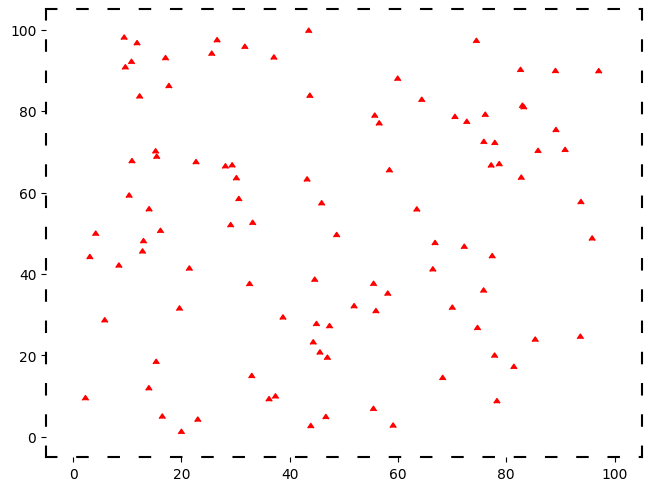

In [1]:
from matplotlib.markers import MarkerStyle
from mesa.examples.basic.boid_flockers.model import BoidFlockers
from mesa.visualization import Slider, SolaraViz, SpaceRenderer
from mesa.visualization.components import AgentPortrayalStyle

# Pre-compute markers for different angles (e.g., every 10 degrees)
MARKER_CACHE = {}
for angle in range(0, 360, 10):
    marker = MarkerStyle(10)
    marker._transform = marker.get_transform().rotate_deg(angle)
    MARKER_CACHE[angle] = marker

def boid_draw(agent):
    neighbors = len(agent.neighbors)
    deg = agent.angle
    rounded_deg = round(deg / 10) * 10 % 360
    boid_style = AgentPortrayalStyle(
        color="red", size=20, marker=MARKER_CACHE[rounded_deg]
    )
    if neighbors >= 2:
        boid_style.update(("color", "green"), ("marker", MARKER_CACHE[rounded_deg]))
    return boid_style

# Define model parameters
model_params = {
    "seed": 42,  # Use a simple integer for the seed
    "population_size": Slider(
        label="Number of boids",
        value=100,
        min=10,
        max=200,
        step=10,
    ),
    "width": 100,
    "height": 100,
    "speed": Slider(
        label="Speed of Boids",
        value=5,
        min=1,
        max=20,
        step=1,
    ),
    "vision": Slider(
        label="Vision of Bird (radius)",
        value=10,
        min=1,
        max=50,
        step=1,
    ),
    "separation": Slider(
        label="Minimum Separation",
        value=2,
        min=1,
        max=20,
        step=1,
    ),
}

# Initialize the model with the parameters
model = BoidFlockers(
    population_size=model_params["population_size"].value,
    width=model_params["width"],
    height=model_params["height"],
    speed=model_params["speed"].value,
    vision=model_params["vision"].value,
    separation=model_params["separation"].value,
    seed=model_params["seed"]
)

renderer = SpaceRenderer(
    model,
    backend="matplotlib",
).render(agent_portrayal=boid_draw)

def update_model():
    model.step()  # Call the model's step function to update the simulation

page = SolaraViz(
    model,
    renderer,
    model_params=model_params,
    name="Boid Flocking Model",
    update=update_model  # Add the update function here
)
page  # noqa
